In [138]:
import string
import re
from collections import defaultdict
import pickle
import gc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models

import os
import tempfile

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

Folder "C:\Users\GyorgyM\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [2]:
tweets_csv = pd.read_csv("Data/twcs.csv")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GyorgyM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GyorgyM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [83]:
tweets_csv.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [123]:
from_user_mask = tweets_csv.author_id.str.match(r'[0-9]+$')
support_channels = tweets_csv[~from_user_mask].author_id.unique()

In [124]:
support_channels

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps',
       'ATVIAssist', 'AdobeCare', 'AmazonHelp', 'XboxSupport',
       'AirbnbHelp', 'nationalrailenq', 'AirAsiaSupport', 'Morrisons',
       'NikeSupport', 'AskAmex', 'McDonalds', 'YahooCare', 'AskLyft',
       'UPSHelp', 'Delta', 'AppleSupport', 'Uber_Support', 'Tesco',
       'SpotifyCares', 'British_Airways', 'comcastcares', 'AmericanAir',
       'TMobileHelp', 'VirginTrains', 'SouthwestAir', 'AskeBay',
       'hulu_support', 'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport',
       'ChaseSupport', 'CoxHelp', 'DropboxSupport', 'VirginAtlantic',
       'BofA_Help', 'AzureSupport', 'AlaskaAir', 'ArgosHelpers',
       'Postmates_Help', 'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp',
       'AskPapaJohns', 'SW_Help', 'askpanera', 'Walmart',
       'USCellularCares', 'AsurionCares', 'GloCare', 'idea_cares',
       'DoorDash_Help', 'NeweggService', 'VirginA

In [125]:
pattern = r"\@(" + "|".join(support_channels) + ")"
print(pattern)
support_channel_mask = tweets_csv.text.str.contains(pattern)
nochannel = tweets_csv[from_user_mask & ~support_channel_mask]

\@(sprintcare|Ask_Spectrum|VerizonSupport|ChipotleTweets|AskPlayStation|marksandspencer|MicrosoftHelps|ATVIAssist|AdobeCare|AmazonHelp|XboxSupport|AirbnbHelp|nationalrailenq|AirAsiaSupport|Morrisons|NikeSupport|AskAmex|McDonalds|YahooCare|AskLyft|UPSHelp|Delta|AppleSupport|Uber_Support|Tesco|SpotifyCares|British_Airways|comcastcares|AmericanAir|TMobileHelp|VirginTrains|SouthwestAir|AskeBay|hulu_support|GWRHelp|sainsburys|AskPayPal|HPSupport|ChaseSupport|CoxHelp|DropboxSupport|VirginAtlantic|BofA_Help|AzureSupport|AlaskaAir|ArgosHelpers|Postmates_Help|AskTarget|GoDaddyHelp|CenturyLinkHelp|AskPapaJohns|SW_Help|askpanera|Walmart|USCellularCares|AsurionCares|GloCare|idea_cares|DoorDash_Help|NeweggService|VirginAmerica|Safaricom_Care|DunkinDonuts|Ask_WellsFargo|O2|TfL|asksalesforce|airtel_care|Kimpton|AskCiti|IHGService|LondonMidland|JetBlue|BoostCare|JackBox|AldiUK|HiltonHelp|GooglePlayMusic|OfficeSupport|KFC_UKI_Help|DellCares|TwitterSupport|GreggsOfficial|ATT|TacoBellTeam|AskRBC|ArbysCar

c:\users\gyorgym\apps\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
nochannel.head(100)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
12,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN
14,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN
23,29,115716,True,Tue Oct 31 22:01:35 +0000 2017,actually that's a broken link you sent me and ...,28,NaN
39,42,115721,True,Tue Oct 31 22:06:21 +0000 2017,@115722 MD. And this was sent to the wrong add...,40,46.0
40,46,115722,True,Tue Oct 31 22:04:29 +0000 2017,"@115721 Hello Duke, Do you have a copy of your...",42,47.0
41,47,115721,True,Tue Oct 31 22:01:42 +0000 2017,@115722 Nobody can find my account or number. ...,46,48.0
42,48,115722,True,Tue Oct 31 21:49:31 +0000 2017,@115721 Are you referring to wireless or resid...,47,49.0
43,49,115721,True,Tue Oct 31 21:42:09 +0000 2017,@115722 tried to pay a bill for 60 days. No se...,48,NaN
53,59,115723,True,Tue Oct 31 19:54:51 +0000 2017,@115722 is the worst ISP I’ve ever had,58,NaN
57,63,115727,True,Tue Oct 31 21:56:55 +0000 2017,@115725 fix your app it won't even open,62,NaN


In [122]:
re.match(r"[0-9]+$", "1sdff") is not None

False

In [3]:
first_mask = tweets_csv.in_response_to_tweet_id.isnull()
first_tweets = tweets_csv.loc[first_mask, ["tweet_id", "text"]].copy()
response_tweets = tweets_csv.loc[~first_mask, ["tweet_id", "text", "in_response_to_tweet_id"]].copy()
response_tweets["in_response_to_tweet_id"] = response_tweets["in_response_to_tweet_id"].astype("int64").values
response_tweets.head()

,tweet_id,text,in_response_to_tweet_id
0,1,@115712 I understand. I would like to assist y...,3
1,2,@sprintcare and how do you propose we do that,1
2,3,@sprintcare I have sent several private messag...,4
3,4,@115712 Please send us a Private Message so th...,5
4,5,@sprintcare I did.,6


In [334]:
tokenizer = RegexpTokenizer(r"[\w'-]+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
num_pattern = re.compile(r"[0-9-]+$")
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")

def get_cleaned_doc(doc):
    url_removed = url_pattern.sub("?", doc)
    lower = url_removed.lower()
    tokenized = tokenizer.tokenize(lower)
    stop_removed = [word for word in tokenized if word not in stop]
    num_removed = [word for word in stop_removed if num_pattern.match(word) is None]
    lemmatized = [lemmatizer.lemmatize(word) for word in num_removed]
    return num_removed

documents = [get_cleaned_doc(doc) for doc in tweets_csv.text]

file_path = os.path.join(TEMP_FOLDER, 'cleaned_docs.obj')
pickle.dump(documents, open(file_path, 'wb'))

In [333]:
r = np.random.randint(len(documents))
print(r)
doc = tweets_csv.text[r]
url_removed = url_pattern.sub("?", doc)
lower = url_removed.lower()
tokenized = tokenizer.tokenize(lower)
stop_removed = [word for word in tokenized if word not in stop]
num_removed = [word for word in stop_removed if num_pattern.match(word) is None]
lemmatized = [lemmatizer.lemmatize(word) for word in num_removed]

print(doc)
print(url_removed)
print(tokenized)
print(stop_removed)
print(num_removed)
# print(lemmatized)

2040607
@AppleSupport so Siri will no longer tweet for me and my battery is draining quicker with iOS11.0.3. Not cool. I’ve had my phone 10 days!
@AppleSupport so Siri will no longer tweet for me and my battery is draining quicker with iOS11.0.3. Not cool. I’ve had my phone 10 days!
['applesupport', 'so', 'siri', 'will', 'no', 'longer', 'tweet', 'for', 'me', 'and', 'my', 'battery', 'is', 'draining', 'quicker', 'with', 'ios11', '0', '3', 'not', 'cool', 'i', 've', 'had', 'my', 'phone', '10', 'days']
['applesupport', 'siri', 'longer', 'tweet', 'battery', 'draining', 'quicker', 'ios11', '0', '3', 'cool', 'phone', '10', 'days']
['applesupport', 'siri', 'longer', 'tweet', 'battery', 'draining', 'quicker', 'ios11', 'cool', 'phone', 'days']


In [335]:
frequency = defaultdict(int)
for doc in documents:
    for token in doc:
        frequency[token] += 1

In [348]:
freq_df = pd.DataFrame.from_dict(frequency, orient="index")
freq_df.columns = ["freq"]

In [353]:
freq_df[freq_df.freq > 100].sort_values("freq").head(100)

,freq
puedas,101
christie,101
warmer,101
ubers,101
tard,101
relieved,101
domingo,101
desconto,101
hoffe,101
knees,101


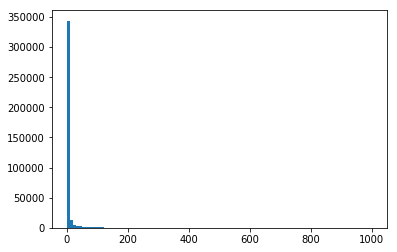

In [336]:
plt.hist(frequency.values(), bins=100, range=(1, 1000));

In [51]:
freq_filtered_docs = [[token for token in doc if frequency[token] > 1] for doc in documents]

In [47]:
tokenizer = RegexpTokenizer(r"[\w'-]+")
tokenizer.tokenize("adf   adf adf#chr non-negotiable y'all")
# re.split("\W+", "adf   adf adf#chr")

['adf', 'adf', 'adf', 'chr', 'non-negotiable', "y'all"]

In [337]:
dictionary = corpora.Dictionary(documents)

file_path = os.path.join(TEMP_FOLDER, 'cleaned_docs.dict')
pickle.dump(documents, open(file_path, 'wb'))

In [340]:
filtered_dict = pickle.load(open(file_path, 'rb'))
filtered_dict.filter_extremes(no_below=1, no_above=1e-6)

EOFError: Ran out of input

In [52]:
freq_filtered_dict = corpora.Dictionary(freq_filtered_docs)

In [338]:
dictionary.num_pos, freq_filtered_dict.num_pos

(28303012, 35218394)

In [21]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in documents]

file_path = os.path.join(TEMP_FOLDER, 'cleaned_docs.dtm')
pickle.dump(documents, open(file_path, 'wb'))

In [24]:
model = models.LdaMulticore(doc_term_matrix, id2word=dictionary, num_topics=100, workers=7)

c:\users\gyorgym\apps\miniconda3\envs\dl\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


KeyboardInterrupt: 